In [ ]:
import os
import time
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from tqdm import tqdm

from sklearn.metrics import mean_squared_error, mean_absolute_error

from arch import arch_model
from fredapi import Fred
import yfinance as yf


In [3]:
# Locate the Project 1 directory to this notebook's working directory
PROJECT_DIR = Path.cwd()
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
OUT_DIR = os.path.join(PROJECT_DIR, 'output')
for d in [DATA_DIR, OUT_DIR]:
    os.makedirs(d, exist_ok=True)

In [4]:
merged = pd.read_csv('data/merged_data.csv', index_col=0, parse_dates=True)

In [5]:
#Delete the first row due to missing values:

merged = merged.iloc[1:].copy()

In [6]:
#Create the garch df with the column ret and rv5 from merged:
garch_df = merged[['ret', 'rv5']]

In [6]:
merged

,Close_S&P,High_S&P,Low_S&P,Open_S&P,Volume_S&P,Close_VIX,High_VIX,Low_VIX,Open_VIX,Close_GOLD,High_GOLD,Low_GOLD,Open_GOLD,Close_OIL,High_OIL,Low_OIL,Open_OIL,rv5,DGS10,ret
Date,,,,,,,,,,,,,,,,,,,,
2001-01-03,1347.560059,1347.760010,1274.619995,1283.270020,1880700000,26.600000,29.959999,25.990000,29.629999,268.000000,268.000000,268.000000,268.000000,27.950001,28.139999,27.049999,27.230000,0.031663,0.0514,0.048884
2001-01-04,1333.339966,1350.239990,1329.140015,1347.560059,2131000000,26.969999,27.190001,26.129999,26.350000,267.299988,267.299988,267.299988,267.299988,28.200001,28.780001,27.850000,28.200001,0.012610,0.0503,-0.010609
2001-01-05,1298.349976,1334.770020,1294.949951,1333.339966,1430800000,28.670000,29.040001,27.209999,27.809999,268.000000,268.000000,268.000000,268.000000,28.000000,28.799999,27.799999,28.150000,0.015626,0.0493,-0.026593
2001-01-08,1295.859985,1298.349976,1276.290039,1298.349976,1115500000,29.840000,30.799999,29.719999,29.980000,268.000000,268.000000,268.000000,268.000000,27.350000,28.400000,27.150000,28.200001,0.009083,0.0494,-0.001920
2001-01-09,1300.800049,1311.719971,1295.140015,1295.859985,1191300000,27.990000,29.530001,27.770000,29.469999,267.500000,267.500000,267.500000,267.500000,27.719999,27.750000,26.900000,27.250000,0.012575,0.0498,0.003805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-10,3909.879883,3931.500000,3884.939941,3920.780029,4837070000,21.990000,23.850000,19.690001,21.639999,1840.599976,1851.099976,1837.000000,1842.599976,58.680000,58.910000,58.080002,58.450001,0.008828,0.0115,-0.000345
2021-02-11,3916.379883,3925.989990,3890.389893,3916.399902,4590960000,21.250000,23.250000,21.110001,22.090000,1824.900024,1845.000000,1820.900024,1840.500000,58.240002,58.709999,57.840000,58.400002,0.006555,0.0116,0.001661
2021-02-12,3934.830078,3937.229980,3905.780029,3911.649902,4135060000,19.969999,22.450001,19.950001,21.600000,1821.599976,1827.500000,1809.199951,1825.000000,59.470001,59.820000,57.410000,57.939999,0.003810,0.0120,0.004700


<h1>GARCH</h1>

In [27]:
def run_garch_sliding_window(df, window_size=1000, refit_freq=20, test_start=1000):
    """
    Performs a Sliding Window GARCH(1,1) forecast.
    Focus: High-quality styling for publication + PDF Saving.
    """
    
    # 1. SETUP & SCALING
    work_df = df.copy()
    work_df['ret_scaled'] = work_df['ret'] * 100  # Scale for optimizer stability
    
    predictions_scaled_var = []
    dates = []
    
    # 2. MAIN LOOP
    for i in tqdm(range(test_start, len(work_df))):
        
        # Define Window
        train_window = work_df['ret_scaled'].iloc[i - window_size : i]
        
        # Re-Fit Step
        if i % refit_freq == 0:
            model = arch_model(train_window, vol='Garch', p=1, q=1, dist='Normal', rescale=False)
            res = model.fit(disp='off', options={'ftol': 1e-2})
            curr_params = res.params
            
        # Forecast Step
        temp_model = arch_model(train_window, vol='Garch', p=1, q=1, dist='Normal', rescale=False)
        forecast = temp_model.fix(curr_params).forecast(horizon=1, reindex=False)
        
        pred_var_scaled = forecast.variance.iloc[-1].values[0]
        predictions_scaled_var.append(pred_var_scaled)
        dates.append(work_df.index[i])
        
    # 3. PROCESS RESULTS
    results = pd.DataFrame(index=dates)
    results['Pred_Var_Decimal'] = np.array(predictions_scaled_var) / 10000
    results['GARCH_Vol'] = np.sqrt(results['Pred_Var_Decimal'])
    
    # Target
    common_idx = results.index.intersection(work_df.index)
    results['True_Vol'] = work_df.loc[common_idx, 'rv5'] 
    
    # 4. METRICS
    y_true = results['True_Vol'].values
    y_pred = results['GARCH_Vol'].values

    # RMSE / MAE
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)

    # R2 vs MEAN
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - y_true.mean())**2)
    r2_mean = 1 - ss_res / ss_tot

    # R2 vs RANDOM WALK (Campbell–Thompson)
    y_lag = y_true[:-1]
    y_now = y_true[1:]
    y_pred_now = y_pred[1:]

    num = np.sum((y_now - y_pred_now)**2)
    den = np.sum((y_now - y_lag)**2)
    r2_rw = 1 - num / den

    print(f"\nRMSE:          {rmse:.6f}")
    print(f"MAE:           {mae:.6f}")
    print(f"R2 (vs mean):  {r2_mean:.6f}")
    print(f"R2 (vs RW):    {r2_rw:.6f}")
    
    # ========================================================
    # 5. PLOTTING & SAVING
    # ========================================================
    
    # Convert to Percentages for the Plot
    plot_dates = results.index
    true_pct = results['True_Vol'] * 100
    pred_pct = results['GARCH_Vol'] * 100
    
    plt.figure(figsize=(14, 7)) 
    
    # Plot Truth
    plt.plot(plot_dates, true_pct, color='silver', linewidth=0.9, alpha=1.0, label='Realised Daily Volatility')
    
    # Plot Forecast
    plt.plot(plot_dates, pred_pct, color='firebrick', linewidth=0.9, alpha = 0.8, label='GARCH Forecast')
    
    # Styling
    plt.title(f'GARCH predictions vs Realised Daily Volatility', fontsize=14, fontweight='bold', pad=15)
    plt.ylabel('Realised Daily Volatility', fontsize=12, fontweight='bold')
    plt.xlabel('Date', fontsize=12, fontweight='bold')
    
    # Axis Formatting
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1)) 
    ax.grid(True, color='#e0e0e0', linestyle='-', linewidth=0.7) 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Legend
    plt.legend(frameon=True, fontsize=11, loc='upper left', framealpha=0.9)
    
    plt.tight_layout()
    
    try:
        file_name = 'garch_forecast_results.pdf'
        save_path = os.path.join(OUT_DIR, file_name)
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
        print(f"Graph successfully saved to: {save_path}")
    except Exception as e:
        print(f"Could not save PDF (check OUT_DIR): {e}")
    
    plt.show()
    
    return results, {
        'RMSE': rmse,
        'MAE': mae,
        'R2_mean': r2_mean,
        'R2_RW': r2_rw
    }


CHecking how the prrediction behave if we vary the windows size

--- Starting Detailed Window Size Grid Search ---
Testing Window Sizes: [252, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
Common Test Start Index: 4020
Total Rows in Data: 5043


100%|██████████| 1023/1023 [00:01<00:00, 619.74it/s]



RMSE: 0.004971
MAE:  0.003460
Graph successfully saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\garch_forecast_results.pdf


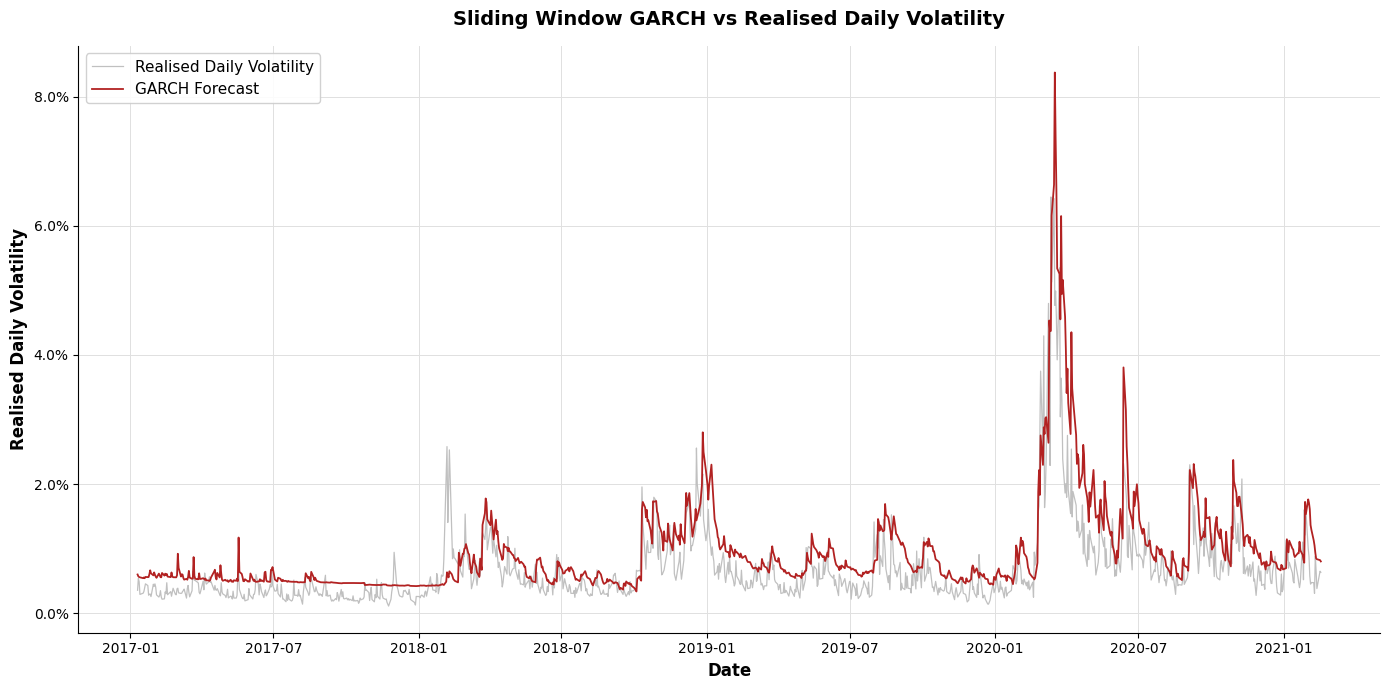

Window=252 | RMSE=0.004971


100%|██████████| 1023/1023 [00:01<00:00, 606.24it/s]



RMSE: 0.005142
MAE:  0.003485
Graph successfully saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\garch_forecast_results.pdf


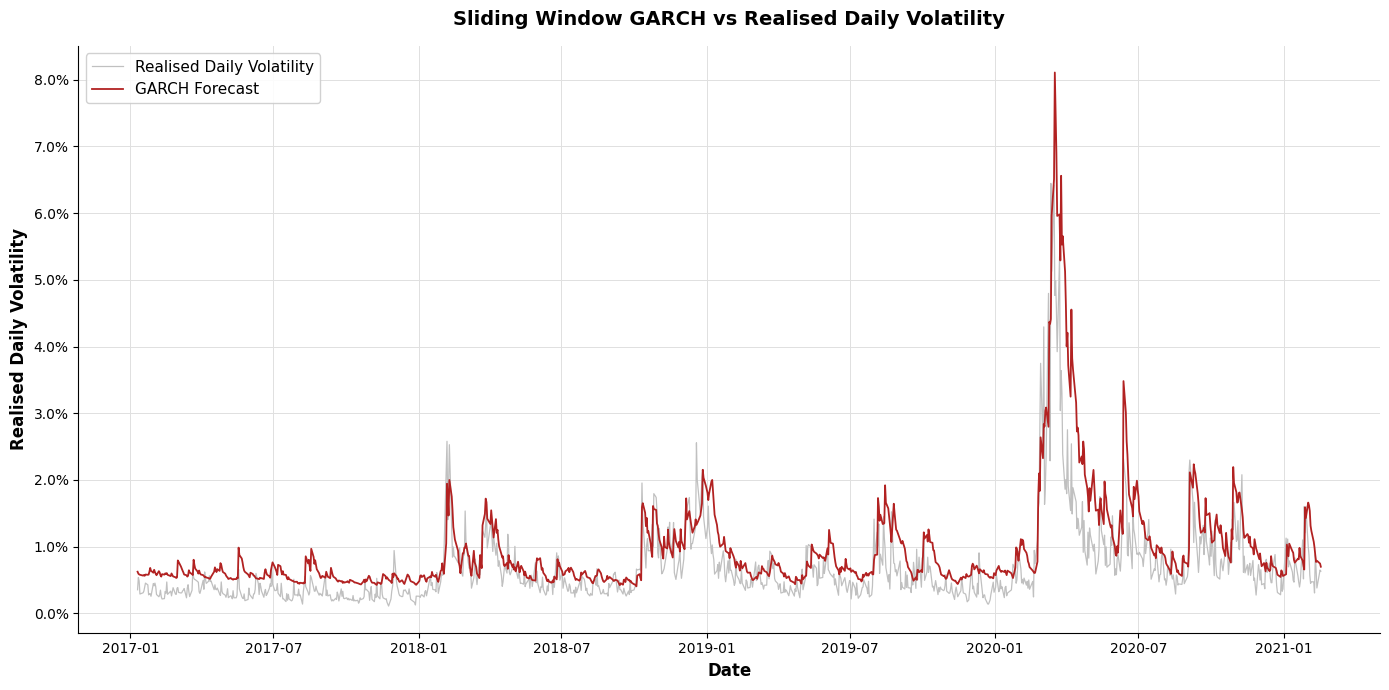

Window=500 | RMSE=0.005142


100%|██████████| 1023/1023 [00:01<00:00, 558.97it/s]



RMSE: 0.005084
MAE:  0.003450
Graph successfully saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\garch_forecast_results.pdf


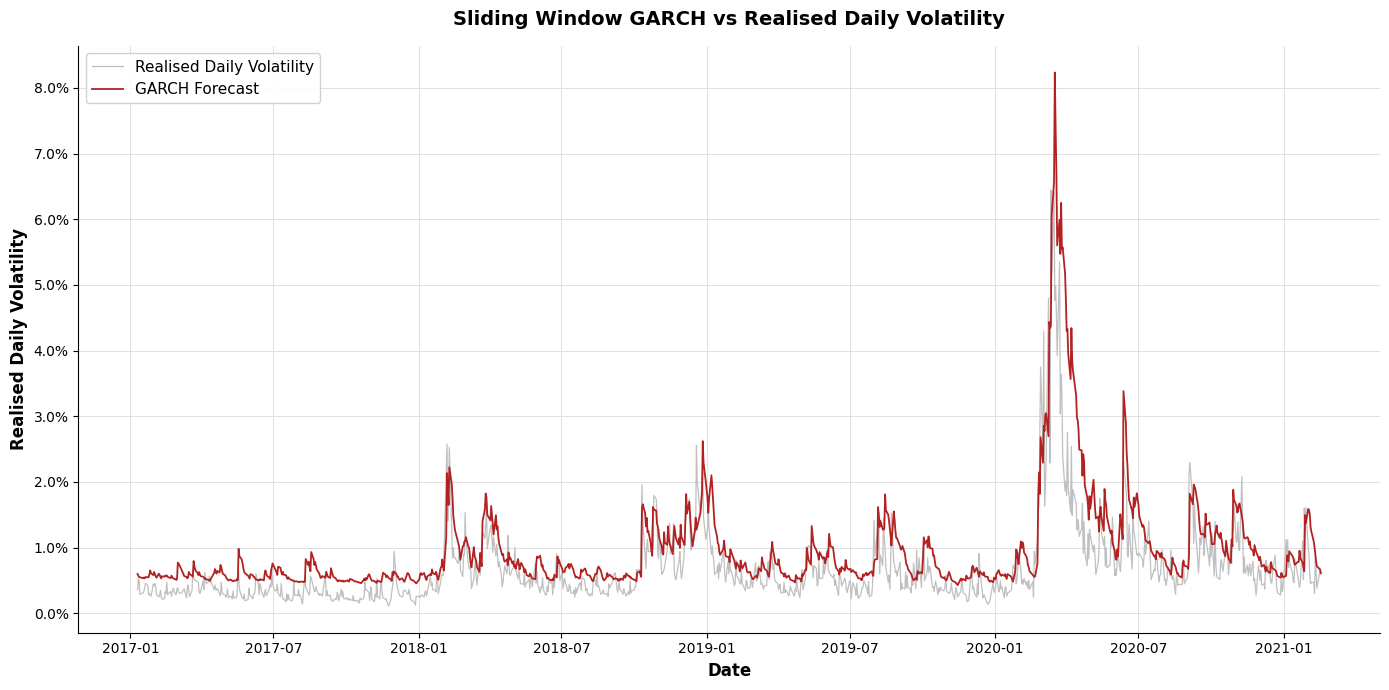

Window=1000 | RMSE=0.005084


100%|██████████| 1023/1023 [00:01<00:00, 530.90it/s]



RMSE: 0.004864
MAE:  0.003464
Graph successfully saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\garch_forecast_results.pdf


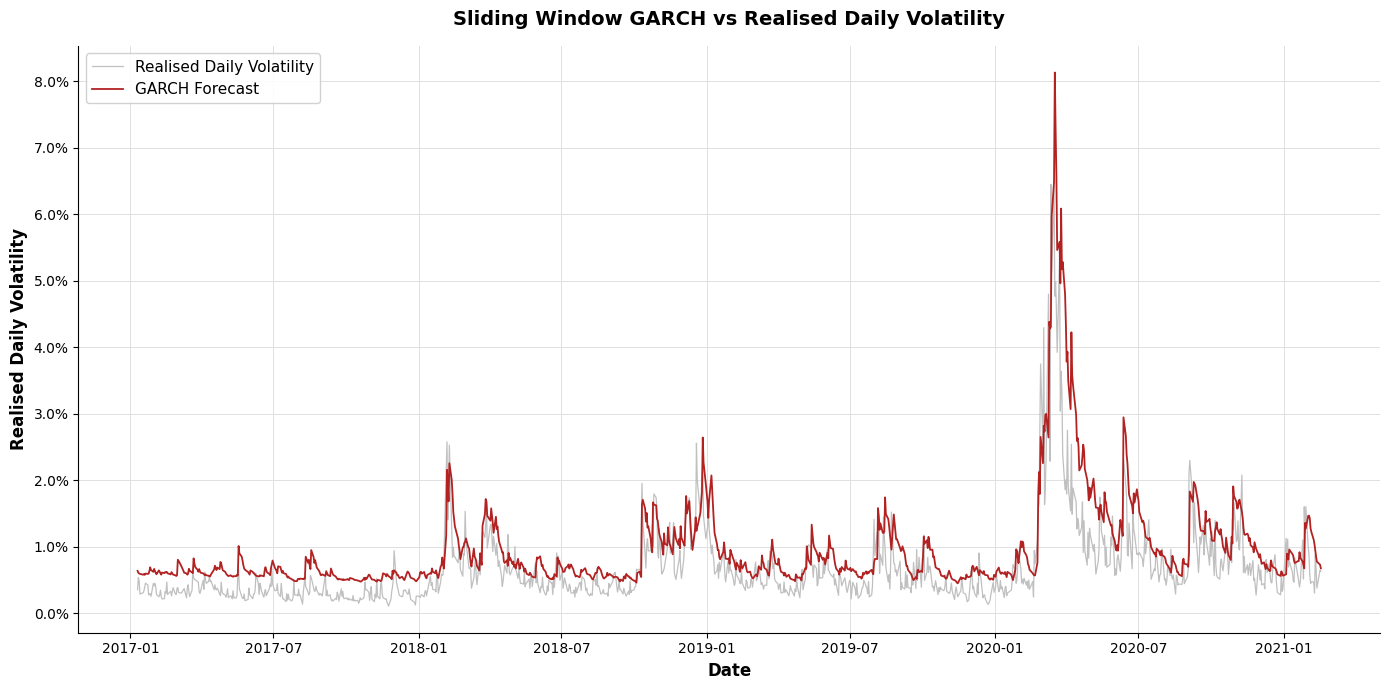

Window=1500 | RMSE=0.004864


100%|██████████| 1023/1023 [00:02<00:00, 478.63it/s]



RMSE: 0.004688
MAE:  0.003416
Graph successfully saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\garch_forecast_results.pdf


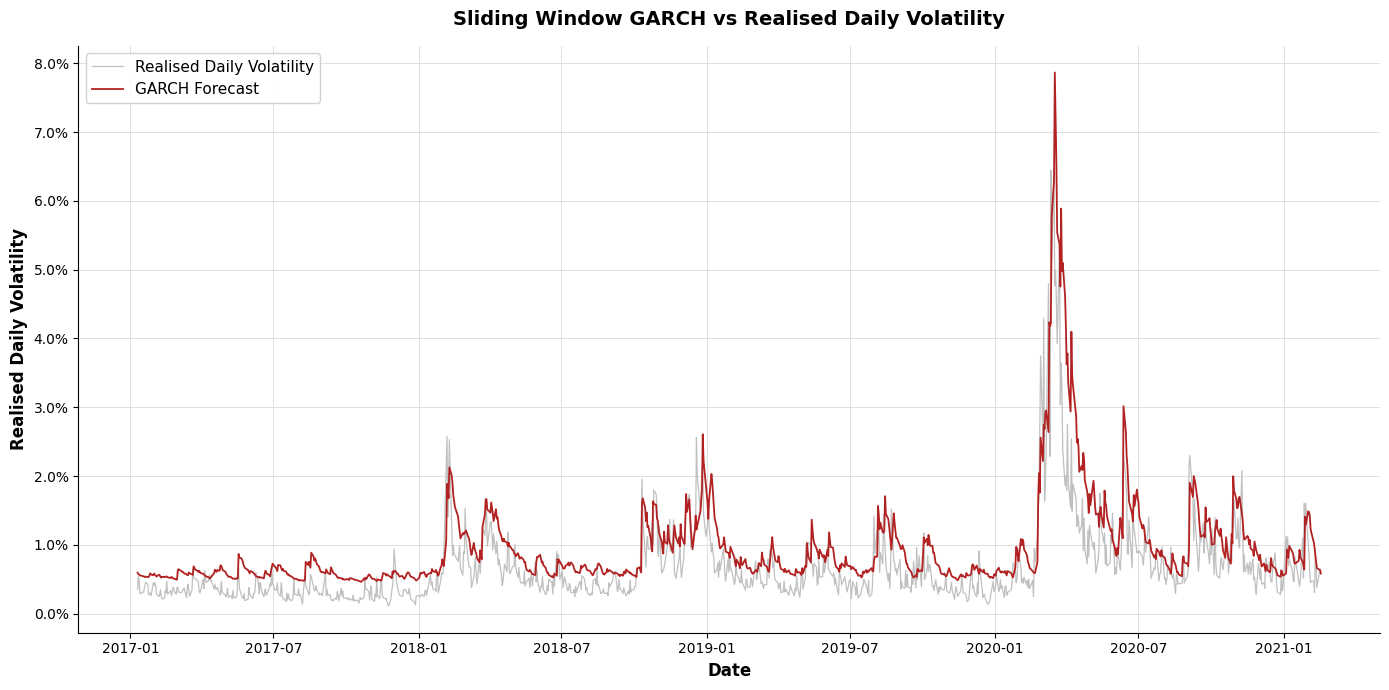

Window=2000 | RMSE=0.004688


100%|██████████| 1023/1023 [00:02<00:00, 456.93it/s]



RMSE: 0.005087
MAE:  0.003644
Graph successfully saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\garch_forecast_results.pdf


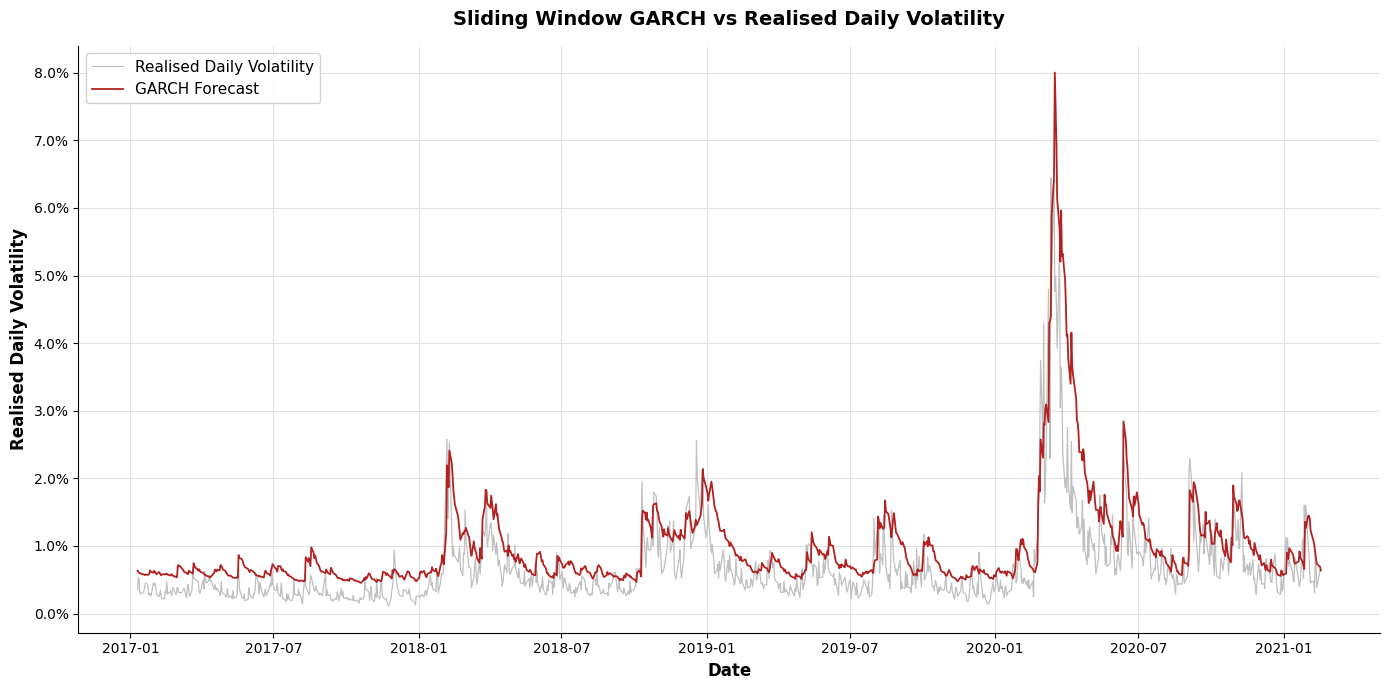

Window=2500 | RMSE=0.005087


100%|██████████| 1023/1023 [00:02<00:00, 443.15it/s]



RMSE: 0.005450
MAE:  0.003824
Graph successfully saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\garch_forecast_results.pdf


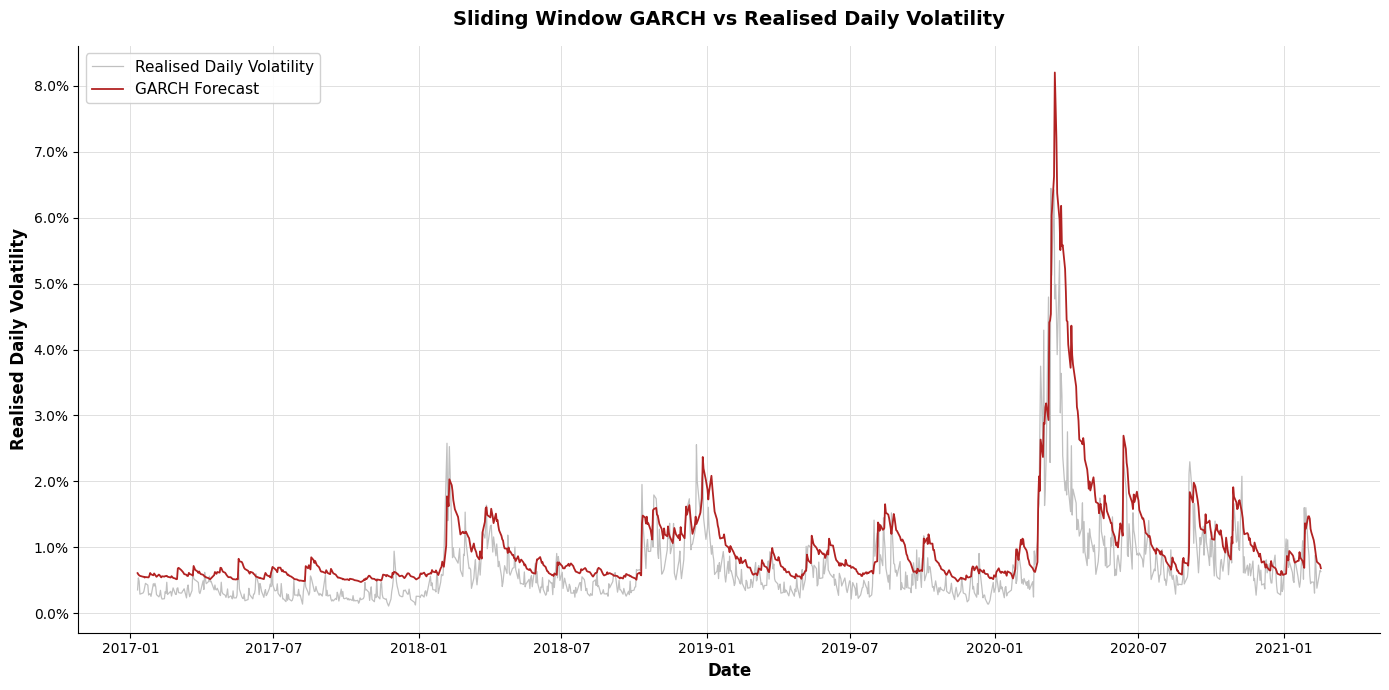

Window=3000 | RMSE=0.005450


100%|██████████| 1023/1023 [00:02<00:00, 423.98it/s]



RMSE: 0.005367
MAE:  0.003744
Graph successfully saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\garch_forecast_results.pdf


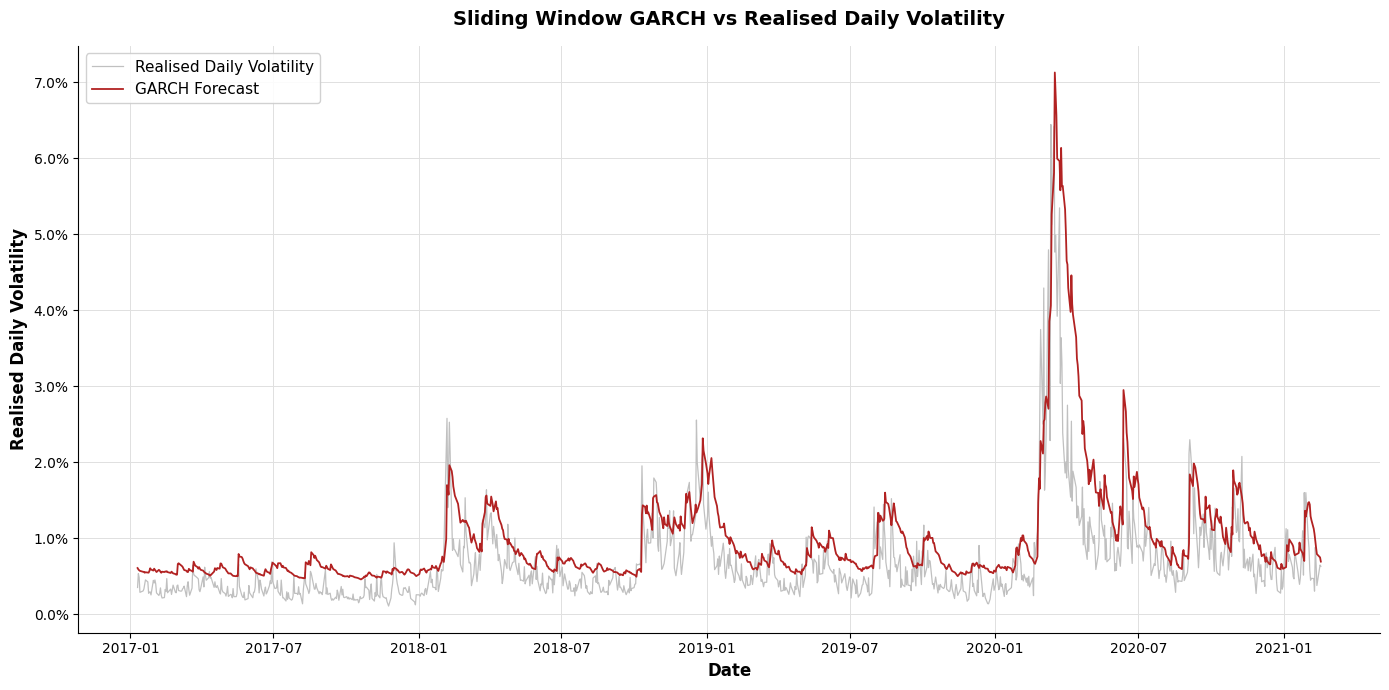

Window=3500 | RMSE=0.005367


100%|██████████| 1023/1023 [00:02<00:00, 428.69it/s]



RMSE: 0.005226
MAE:  0.003746
Graph successfully saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\garch_forecast_results.pdf


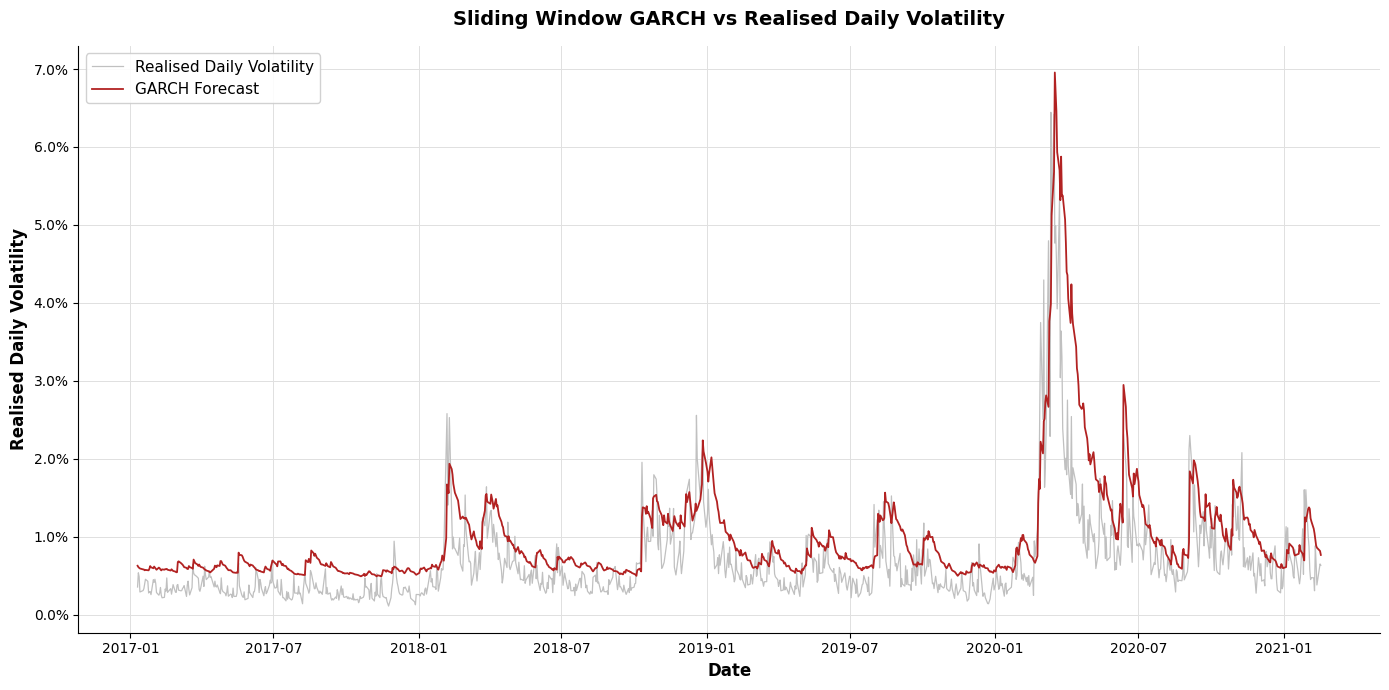

Window=4000 | RMSE=0.005226


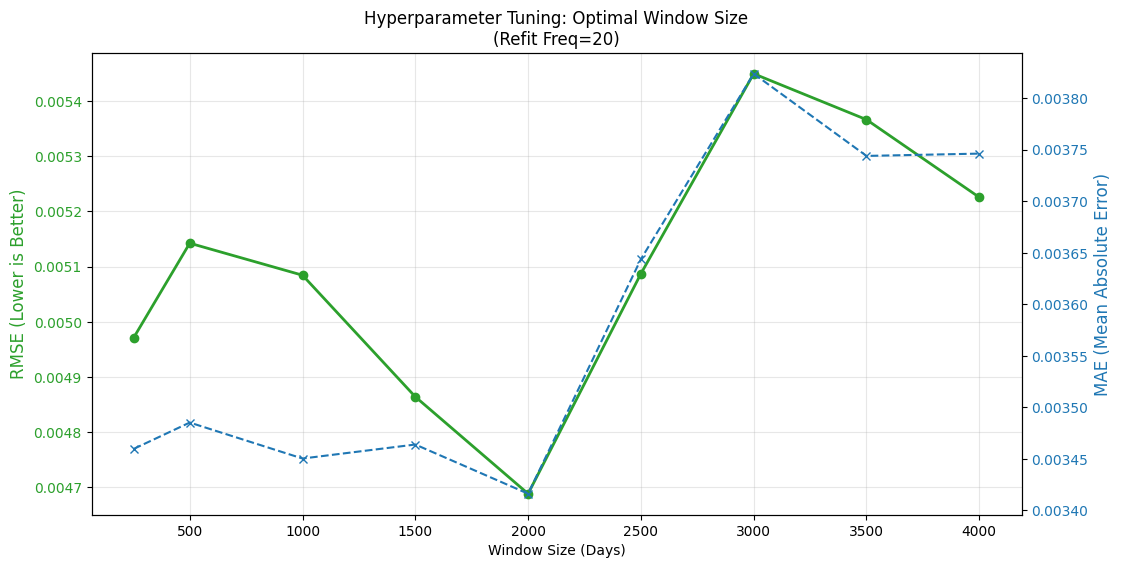


Optimal Window Size Results (Sorted by RMSE):
                 RMSE       MAE      Time
Window_Size                              
2000         0.004688  0.003416  2.510749
1500         0.004864  0.003464  2.260742
252          0.004971  0.003460  1.952834
1000         0.005084  0.003450  2.151356
2500         0.005087  0.003644  2.549831
500          0.005142  0.003485  2.023564
4000         0.005226  0.003746  2.696303
3500         0.005367  0.003744  2.773109
3000         0.005450  0.003824  2.636217


In [ ]:


# 1. Define the Detailed Grid
# Added 2500 and 3500 as requested. Max is still 4000 to fit in dataset.
window_grid = [252, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]

# Fixed Refit Frequency
FIXED_REFIT = 20 

# Store results
window_results = {}

# 2. Dynamic Test Start
# We start testing after the largest window is satisfied.
required_history = max(window_grid)
common_test_start = required_history + 20 

print(f"--- Starting Detailed Window Size Grid Search ---")
print(f"Testing Window Sizes: {window_grid}")
print(f"Common Test Start Index: {common_test_start}")
print(f"Total Rows in Data: {len(garch_df)}")

# Safety Check
if common_test_start >= len(garch_df):
    print("ERROR: Window size too large for dataset. Please reduce max window.")
else:
    for w_size in window_grid:
        start_time = time.time()
        
        try:
            # Run Model
            _, metrics = run_garch_sliding_window(
                garch_df, 
                window_size=w_size, 
                refit_freq=FIXED_REFIT, 
                test_start=common_test_start
            )
            
            elapsed = time.time() - start_time
            
            window_results[w_size] = {
                'RMSE': metrics['RMSE'],
                'MAE': metrics['MAE'],
                'Time': elapsed
            }
            print(f"Window={w_size} | RMSE={metrics['RMSE']:.6f}")
            
        except Exception as e:
            print(f"Window={w_size} failed: {e}")

    # 3. Visualize Results
    results_df = pd.DataFrame(window_results).T
    results_df.index.name = 'Window_Size'

    # Plot
    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:green'
    ax1.set_xlabel('Window Size (Days)')
    ax1.set_ylabel('RMSE (Lower is Better)', color=color, fontsize=12)
    ax1.plot(results_df.index, results_df['RMSE'], color=color, marker='o', linewidth=2, label='RMSE')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, alpha=0.3)
    
    # Secondary Axis for MAE
    ax2 = ax1.twinx()
    color2 = 'tab:blue'
    ax2.set_ylabel('MAE (Mean Absolute Error)', color=color2, fontsize=12)
    ax2.plot(results_df.index, results_df['MAE'], color=color2, marker='x', linestyle='--', label='MAE')
    ax2.tick_params(axis='y', labelcolor=color2)

    plt.title(f'Hyperparameter Tuning: Optimal Window Size\n(Refit Freq={FIXED_REFIT})')
    plt.show()

    print("\nOptimal Window Size Results (Sorted by RMSE):")
    print(results_df.sort_values('RMSE'))

<h1>GARCH DEFINITIVE MODEL</h1>

100%|██████████| 3043/3043 [00:06<00:00, 483.96it/s]



RMSE:          0.004291
MAE:           0.003228
R2 (vs mean):  0.436942
R2 (vs RW):    -0.367188
Graph successfully saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\garch_forecast_results.pdf


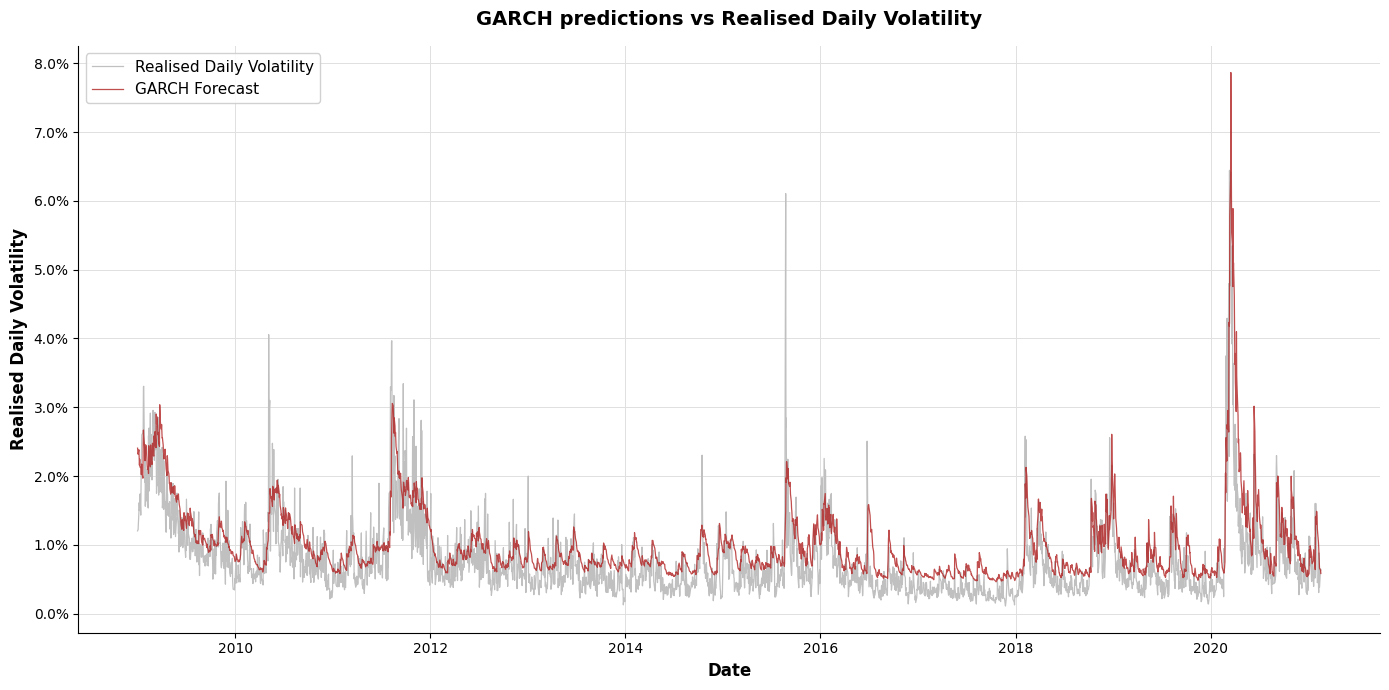

In [28]:
#USAGE DE LA BONNE FONCTION DEFINITIVE POUR LE GARCH:
results_garch, metrics_garch = run_garch_sliding_window(garch_df, window_size=2000, refit_freq=20, test_start=2000)

<h1>EGARCH</h1>

In [ ]:


def run_egarch_sliding_window(df, window_size=1000, refit_freq=20, test_start=1000):
    """
    Performs a Sliding Window E-GARCH(1,1) forecast.
    Focus: High-quality styling for publication + PDF Saving.
    """
    
    # 1. SETUP & SCALING
    work_df = df.copy()
    work_df['ret_scaled'] = work_df['ret'] * 100  # Scale for optimizer stability
    
    predictions_scaled_var = []
    dates = []
    
    # 2. MAIN LOOP
    for i in tqdm(range(test_start, len(work_df))):
        
        # Define Window
        train_window = work_df['ret_scaled'].iloc[i - window_size : i]
        
        # Re-Fit Step
        if i % refit_freq == 0:
            # vol='EGarch', p=1, o=1, q=1 handles the leverage effect
            model = arch_model(train_window, vol='EGarch', p=1, o=1, q=1,
                               dist='Normal', rescale=False)
            res = model.fit(disp='off', options={'ftol': 1e-2})
            curr_params = res.params
            
        # Forecast Step
        temp_model = arch_model(train_window, vol='EGarch', p=1, o=1, q=1,
                                dist='Normal', rescale=False)
        forecast = temp_model.fix(curr_params).forecast(horizon=1, reindex=False)
        
        pred_var_scaled = forecast.variance.iloc[-1].values[0]
        predictions_scaled_var.append(pred_var_scaled)
        dates.append(work_df.index[i])
        
    # 3. PROCESS RESULTS
    results = pd.DataFrame(index=dates)
    results['Pred_Var_Decimal'] = np.array(predictions_scaled_var) / 10000
    results['EGARCH_Vol'] = np.sqrt(results['Pred_Var_Decimal'])
    
    # Target
    common_idx = results.index.intersection(work_df.index)
    results['True_Vol'] = work_df.loc[common_idx, 'rv5']
    
    # 4. METRICS
    y_true = results['True_Vol'].values
    y_pred = results['EGARCH_Vol'].values

    # RMSE / MAE
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)

    # R2 vs MEAN (standard regression-style)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - y_true.mean()) ** 2)
    r2_mean = 1 - ss_res / ss_tot

    # R2 vs RANDOM WALK (Campbell–Thompson OOS R2)
    # benchmark: y_{t-1}
    y_lag = y_true[:-1]
    y_now = y_true[1:]
    y_pred_now = y_pred[1:]

    num = np.sum((y_now - y_pred_now) ** 2)
    den = np.sum((y_now - y_lag) ** 2)
    r2_rw = 1 - num / den

    print(f"\nRMSE (EGARCH):          {rmse:.6f}")
    print(f"MAE  (EGARCH):          {mae:.6f}")
    print(f"R2 (vs mean, EGARCH):   {r2_mean:.6f}")
    print(f"R2 (vs RW, EGARCH):     {r2_rw:.6f}")
    
    # ========================================================
    # 5. PLOTTING & SAVING
    # ========================================================
    plot_dates = results.index
    true_pct = results['True_Vol'] * 100
    pred_pct = results['EGARCH_Vol'] * 100
    
    plt.figure(figsize=(14, 7)) 



    
    # Plot Truth
    plt.plot(plot_dates, true_pct, color='silver', linewidth=0.9, alpha=1.0,
             label='Realised Daily Volatility')
    
    plt.plot(plot_dates, pred_pct,
         color='firebrick', linewidth=0.9, alpha=0.8,
         label='E-GARCH Forecast')

    
    # Styling
    plt.title(' E-GARCH Predictions vs Realised Daily Volatility',
              fontsize=14, fontweight='bold', pad=15)
    plt.ylabel('Realised Daily Volatility', fontsize=12, fontweight='bold')
    plt.xlabel('Date', fontsize=12, fontweight='bold')
    
    # Axis Formatting
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
    ax.grid(True, color="#e0e0e0", linestyle='-', linewidth=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0, 8) 
    
    # Legend
    plt.legend(frameon=True, fontsize=11, loc='upper left', framealpha=0.9)
    
    plt.tight_layout()
    
    try:
        file_name = 'egarch_forecast_results.pdf'
        save_path = os.path.join(OUT_DIR, file_name)
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
        print(f"Graph successfully saved to: {save_path}")
    except Exception as e:
        print(f"Could not save PDF (check OUT_DIR configuration): {e}")
    
    plt.show()
    
    return results, {
        'RMSE': rmse,
        'MAE': mae,
        'R2_mean': r2_mean,
        'R2_RW': r2_rw
    }


CHecking how the prrediction behave if we vary the windows size

--- Starting E-GARCH Window Size Grid Search ---
Testing Window Sizes: [252, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
Common Test Start Index: 4020


100%|██████████| 1023/1023 [00:01<00:00, 555.78it/s]



RMSE: 0.005384
MAE:  0.003508
Graph successfully saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\egarch_forecast_results.pdf


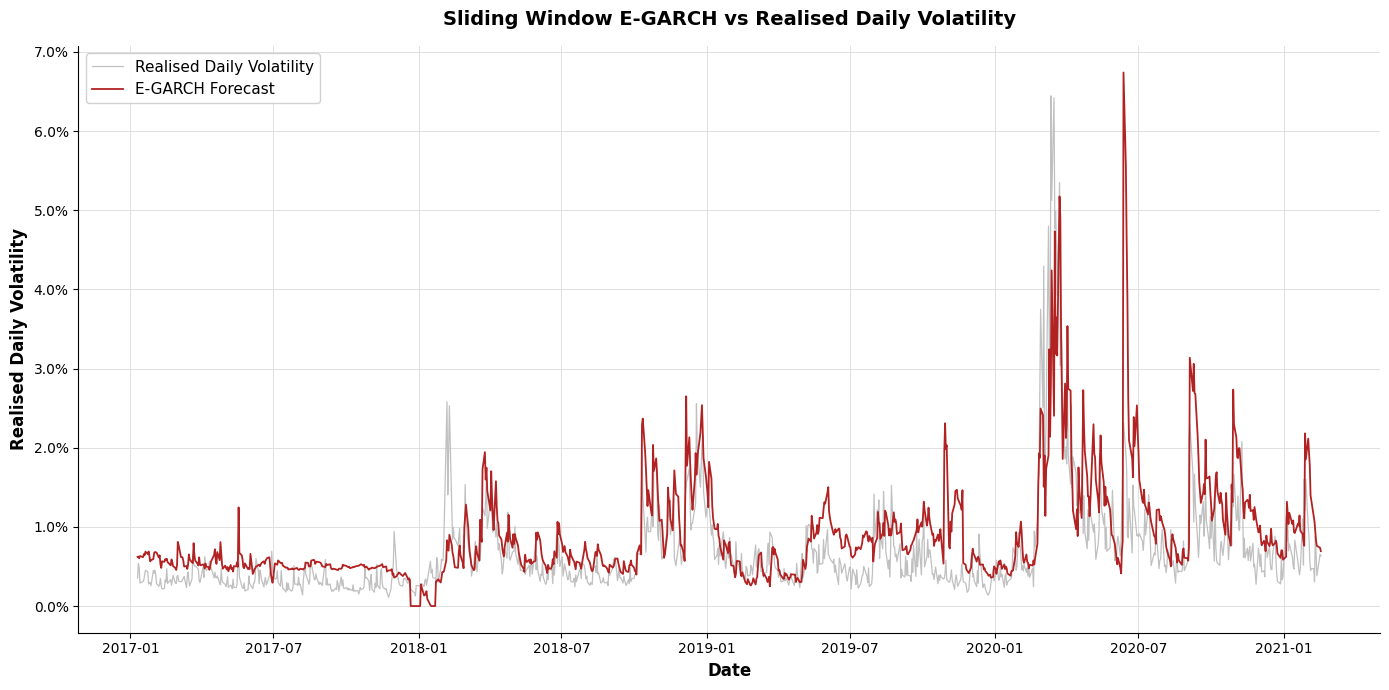

Window=252 | RMSE=0.005384


100%|██████████| 1023/1023 [00:01<00:00, 538.71it/s]



RMSE: 0.004463
MAE:  0.003024
Graph successfully saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\egarch_forecast_results.pdf


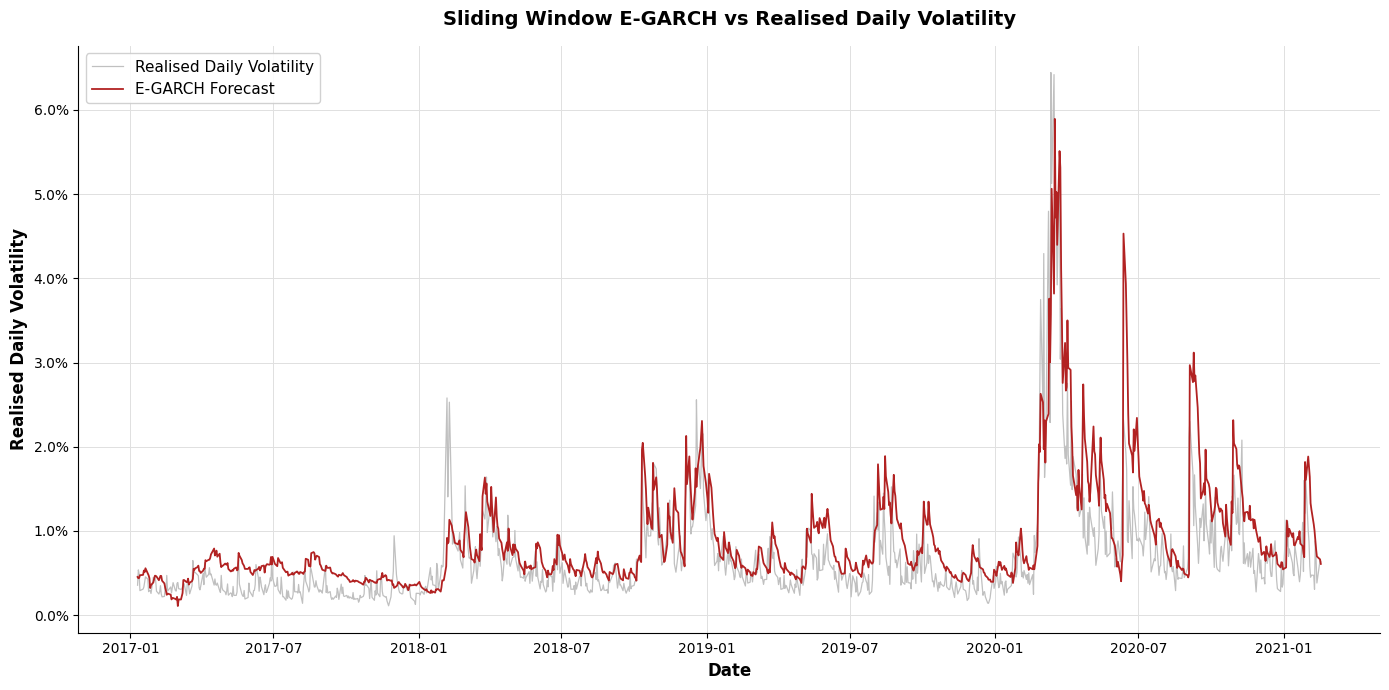

Window=500 | RMSE=0.004463


100%|██████████| 1023/1023 [00:02<00:00, 476.01it/s]



RMSE: 0.004087
MAE:  0.002960
Graph successfully saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\egarch_forecast_results.pdf


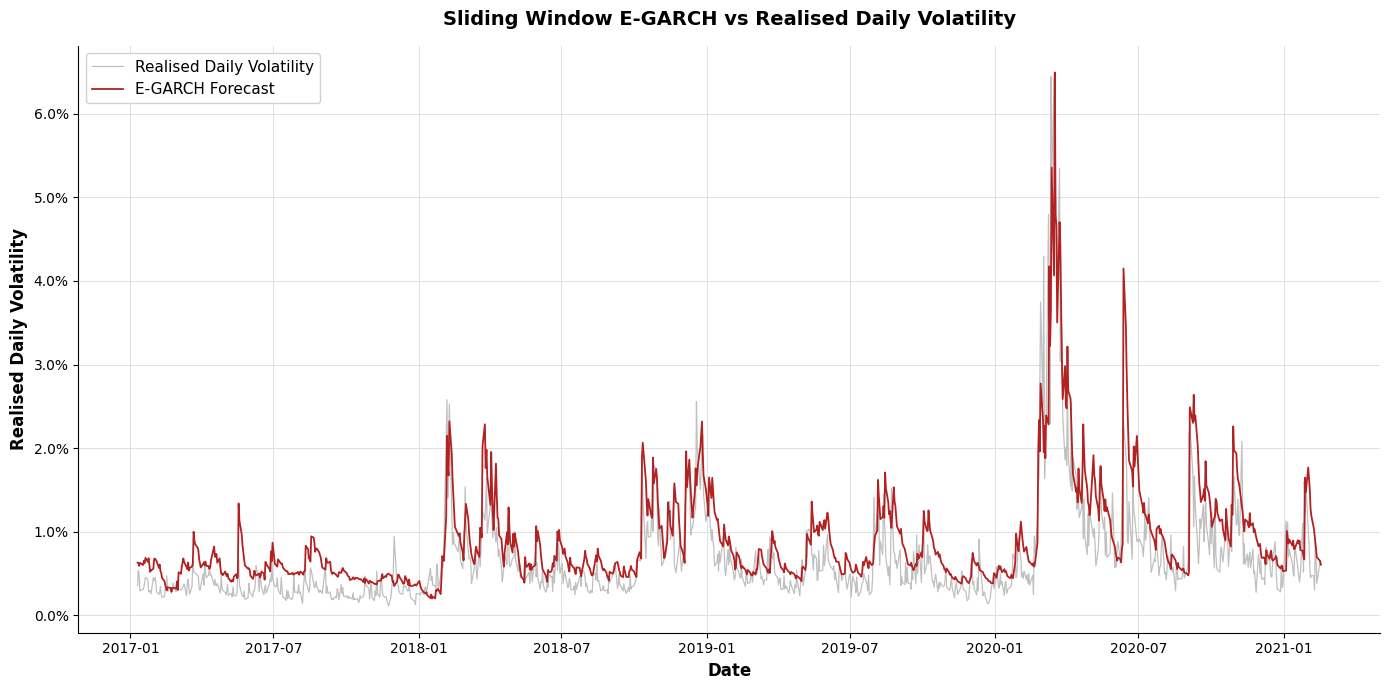

Window=1000 | RMSE=0.004087


100%|██████████| 1023/1023 [00:02<00:00, 442.96it/s]



RMSE: 0.003965
MAE:  0.002840
Graph successfully saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\egarch_forecast_results.pdf


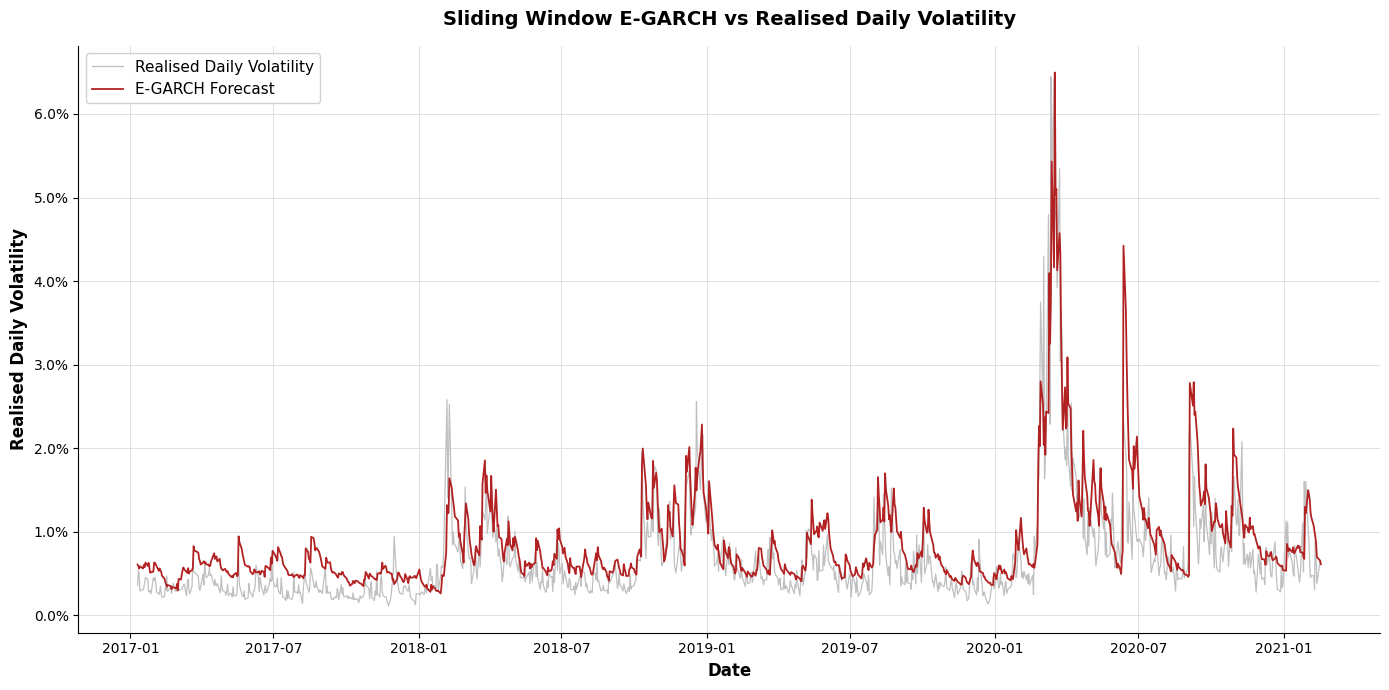

Window=1500 | RMSE=0.003965


100%|██████████| 1023/1023 [00:02<00:00, 388.78it/s]



RMSE: 0.004037
MAE:  0.002970
Graph successfully saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\egarch_forecast_results.pdf


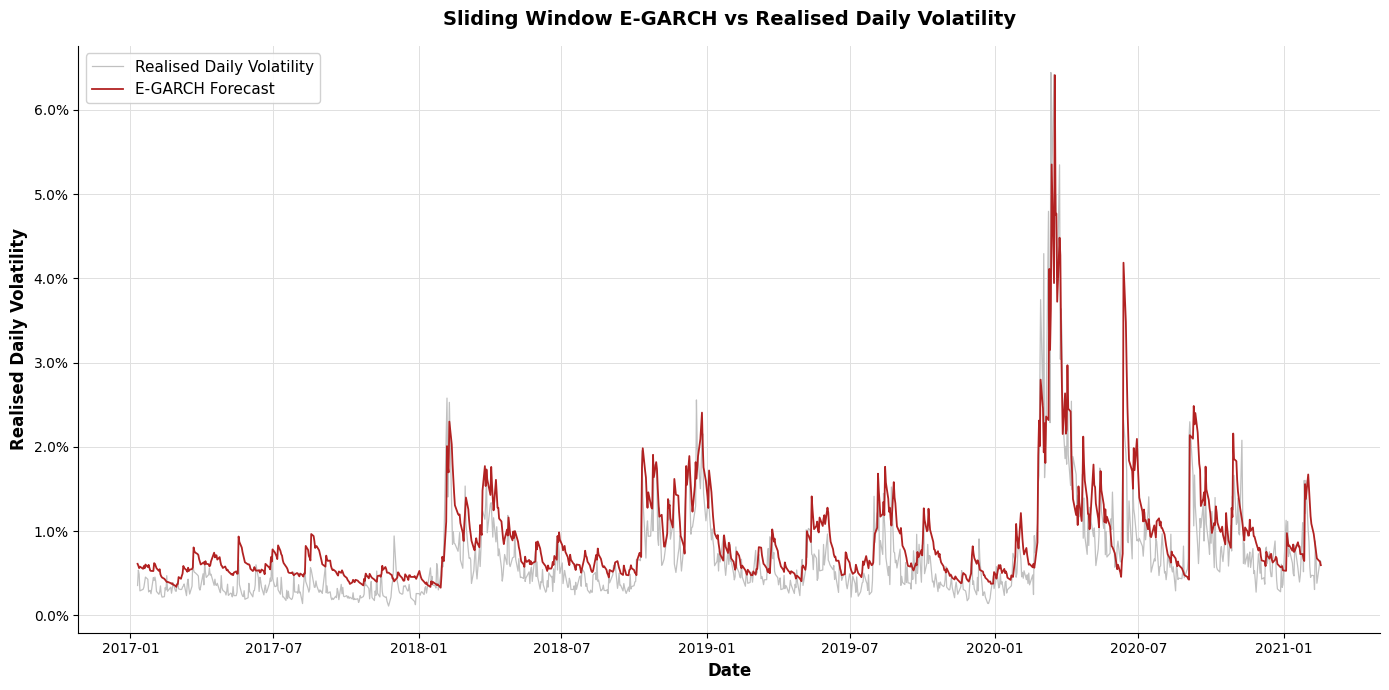

Window=2000 | RMSE=0.004037


100%|██████████| 1023/1023 [00:02<00:00, 369.03it/s]



RMSE: 0.004224
MAE:  0.003191
Graph successfully saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\egarch_forecast_results.pdf


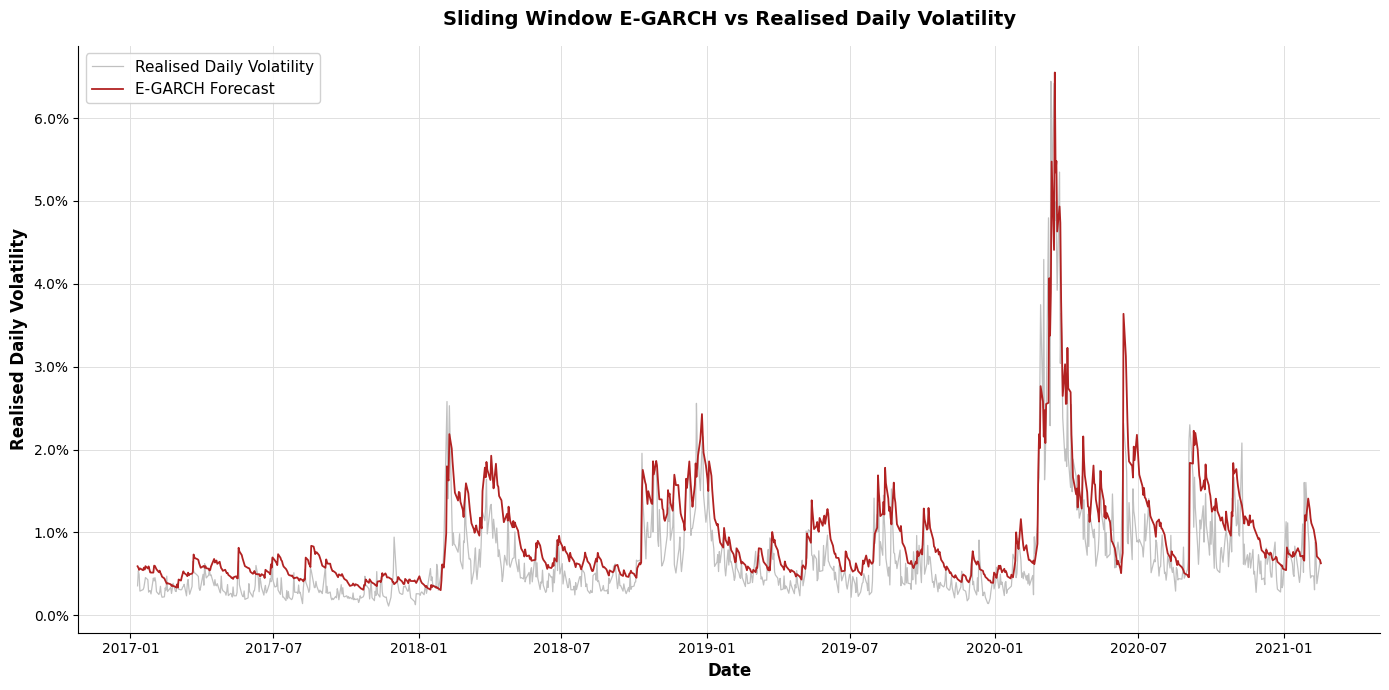

Window=2500 | RMSE=0.004224


100%|██████████| 1023/1023 [00:03<00:00, 336.88it/s]



RMSE: 0.005166
MAE:  0.003575
Graph successfully saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\egarch_forecast_results.pdf


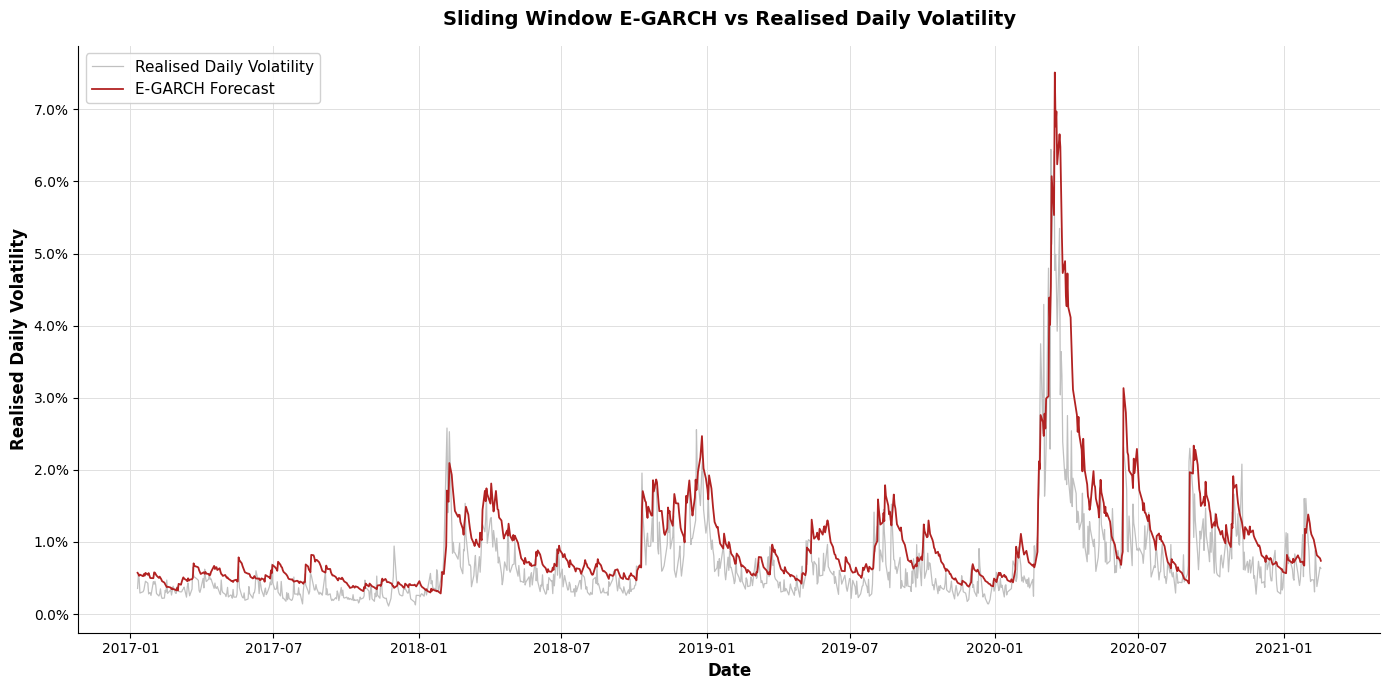

Window=3000 | RMSE=0.005166


100%|██████████| 1023/1023 [00:03<00:00, 313.45it/s]



RMSE: 0.004381
MAE:  0.003258
Graph successfully saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\egarch_forecast_results.pdf


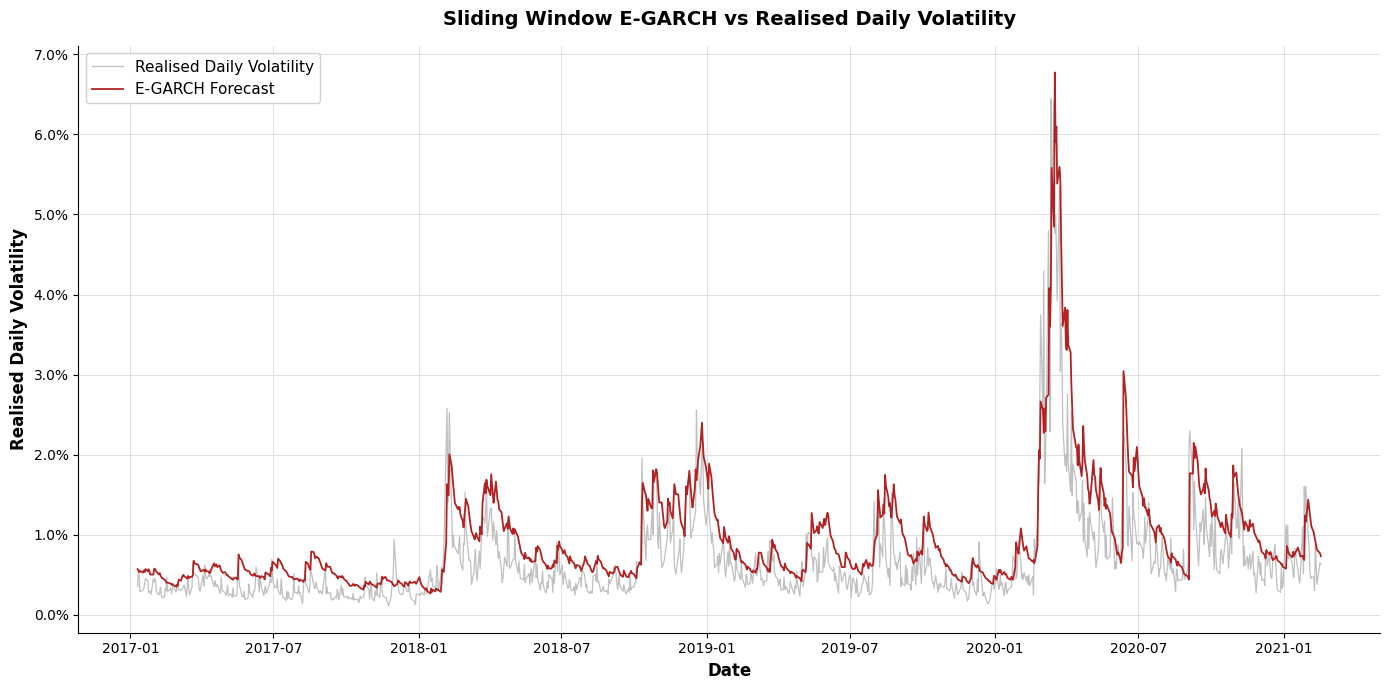

Window=3500 | RMSE=0.004381


100%|██████████| 1023/1023 [00:03<00:00, 295.74it/s]



RMSE: 0.004342
MAE:  0.003233
Graph successfully saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\egarch_forecast_results.pdf


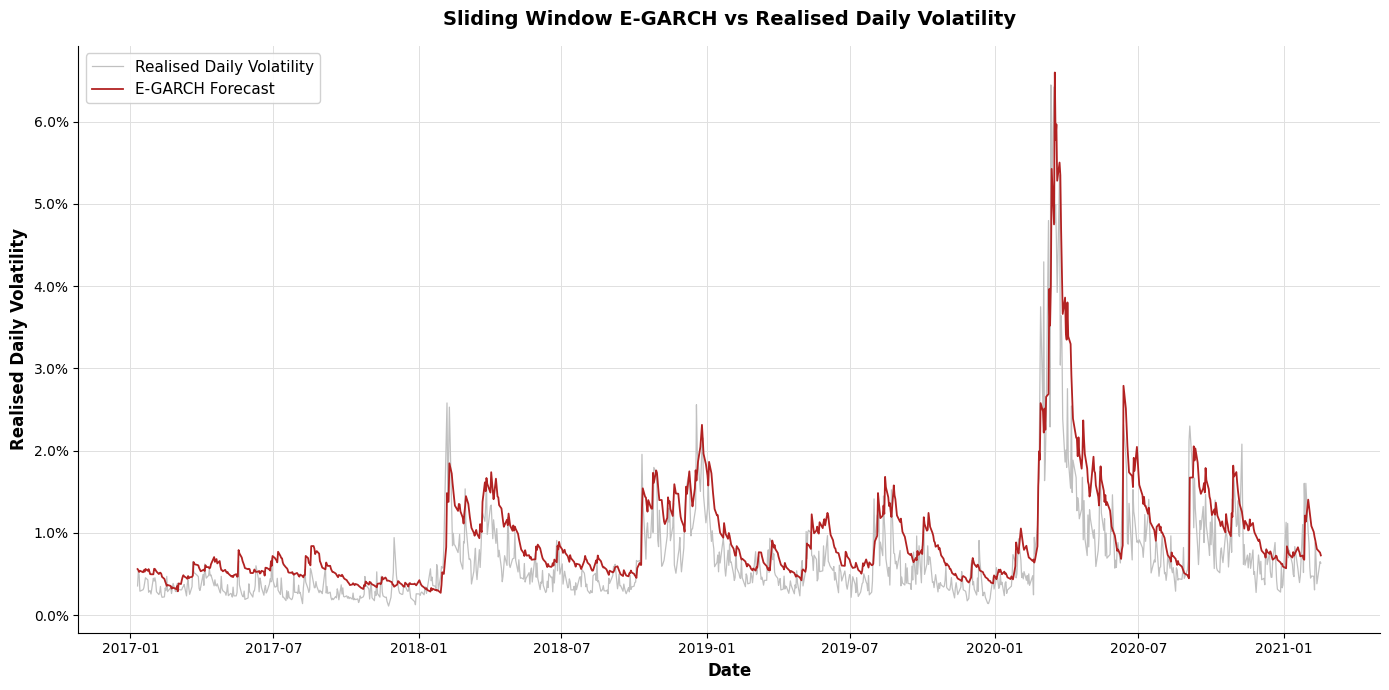

Window=4000 | RMSE=0.004342


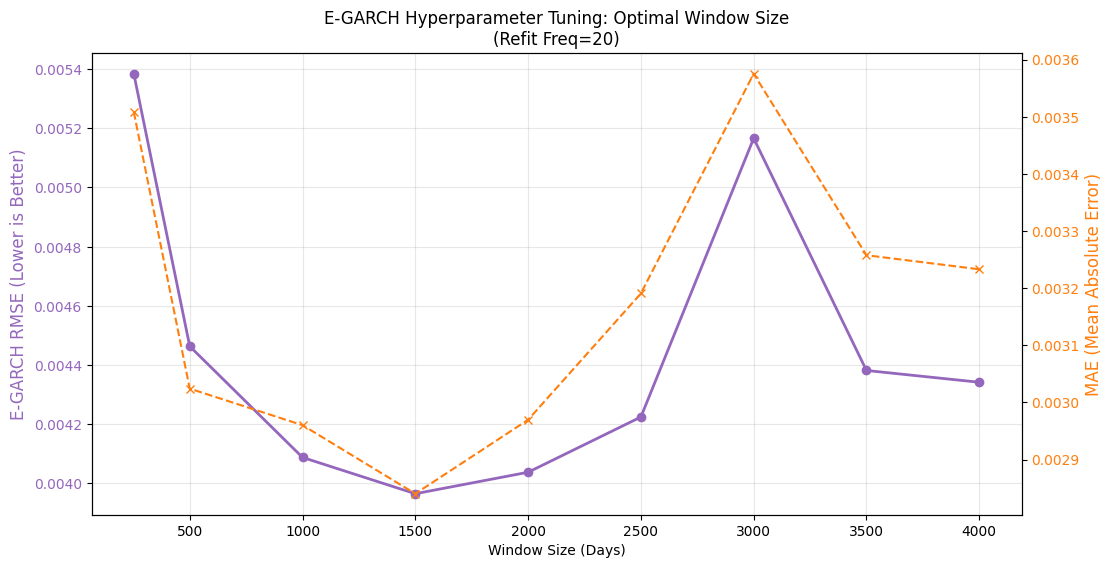


Optimal E-GARCH Window Size Results (Sorted by RMSE):
                 RMSE       MAE      Time
Window_Size                              
1500         0.003965  0.002840  2.629850
2000         0.004037  0.002970  2.962721
1000         0.004087  0.002960  2.465182
2500         0.004224  0.003191  3.089962
4000         0.004342  0.003233  3.787966
3500         0.004381  0.003258  3.614760
500          0.004463  0.003024  2.218202
3000         0.005166  0.003575  3.358589
252          0.005384  0.003508  2.180558


In [39]:


# ========================================================
# 2. RUN THE GRID SEARCH
# ========================================================

# Define the Grid (Same as GARCH for fair comparison)
window_grid = [252, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]

# Fixed Refit Frequency
FIXED_REFIT = 20 

# Store results
egarch_window_results = {}

# Dynamic Test Start (Must ensure fairness by testing exact same period)
required_history = max(window_grid)
common_test_start = required_history + 20 

print(f"--- Starting E-GARCH Window Size Grid Search ---")
print(f"Testing Window Sizes: {window_grid}")
print(f"Common Test Start Index: {common_test_start}")

if common_test_start >= len(garch_df):
    print("ERROR: Window size too large for dataset.")
else:
    for w_size in window_grid:
        start_time = time.time()
        
        try:
            # Call the E-GARCH function
            _, metrics = run_egarch_sliding_window(
                garch_df, 
                window_size=w_size, 
                refit_freq=FIXED_REFIT, 
                test_start=common_test_start
            )
            
            elapsed = time.time() - start_time
            
            egarch_window_results[w_size] = {
                'RMSE': metrics['RMSE'],
                'MAE': metrics['MAE'],
                'Time': elapsed
            }
            print(f"Window={w_size} | RMSE={metrics['RMSE']:.6f}")
            
        except Exception as e:
            print(f"Window={w_size} failed: {e}")

    # ========================================================
    # 3. VISUALIZE RESULTS
    # ========================================================
    results_df = pd.DataFrame(egarch_window_results).T
    results_df.index.name = 'Window_Size'

    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:purple' # Different color for E-GARCH
    ax1.set_xlabel('Window Size (Days)')
    ax1.set_ylabel('E-GARCH RMSE (Lower is Better)', color=color, fontsize=12)
    ax1.plot(results_df.index, results_df['RMSE'], color=color, marker='o', linewidth=2, label='RMSE')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, alpha=0.3)
    
    ax2 = ax1.twinx()
    color2 = 'tab:orange'
    ax2.set_ylabel('MAE (Mean Absolute Error)', color=color2, fontsize=12)
    ax2.plot(results_df.index, results_df['MAE'], color=color2, marker='x', linestyle='--', label='MAE')
    ax2.tick_params(axis='y', labelcolor=color2)

    plt.title(f'E-GARCH Hyperparameter Tuning: Optimal Window Size\n(Refit Freq={FIXED_REFIT})')
    plt.show()

    print("\nOptimal E-GARCH Window Size Results (Sorted by RMSE):")
    print(results_df.sort_values('RMSE'))

<h1>DEFINITIVE MODEL</h1>

100%|██████████| 3043/3043 [00:07<00:00, 410.79it/s]



RMSE (EGARCH):          0.003907
MAE  (EGARCH):          0.002967
R2 (vs mean, EGARCH):   0.533061
R2 (vs RW, EGARCH):     -0.135246
Graph successfully saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\egarch_forecast_results.pdf


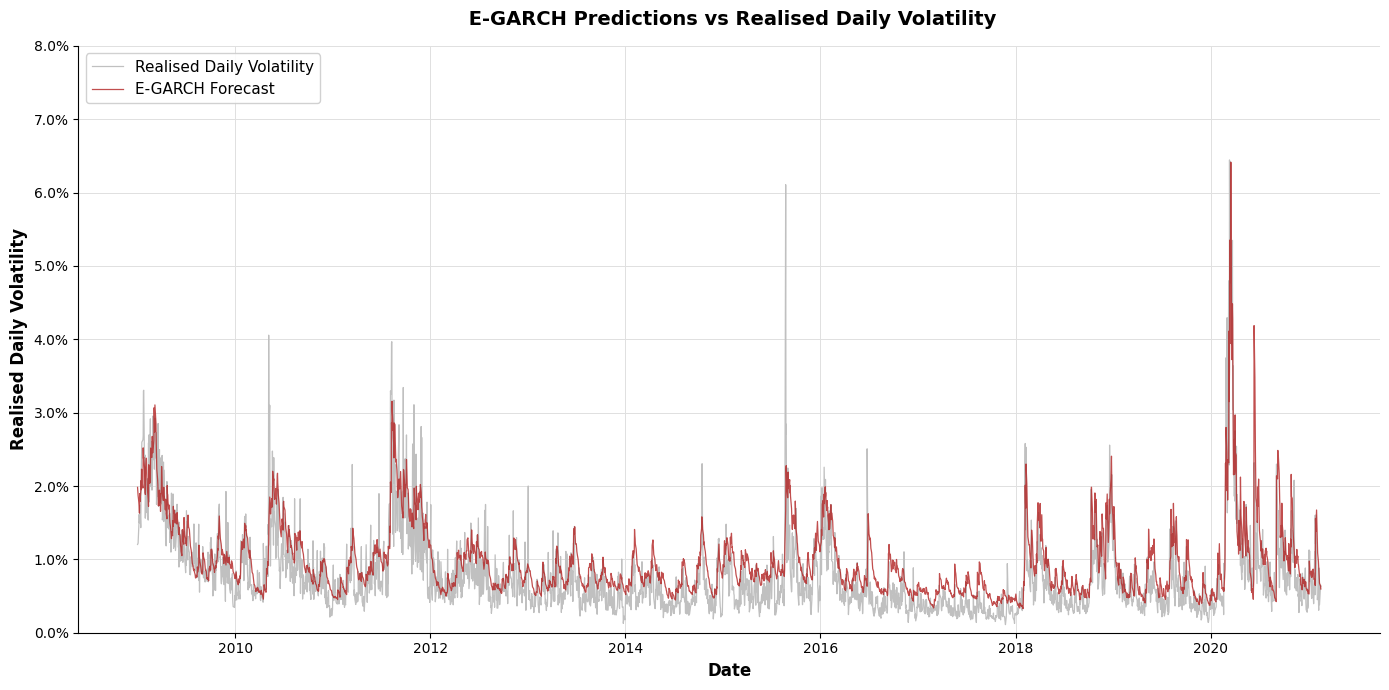

In [23]:
results_egarch, metrics_egarch = run_egarch_sliding_window(
    garch_df, 
    window_size=2000, 
    refit_freq=20, 
    test_start=2000
)

In [29]:
results_egarch

,Pred_Var_Decimal,EGARCH_Vol,True_Vol
2008-12-31,0.000393,0.019814,0.012032
2009-01-02,0.000350,0.018705,0.012212
2009-01-05,0.000315,0.017747,0.014745
2009-01-06,0.000297,0.017248,0.016128
2009-01-07,0.000266,0.016310,0.014975
...,...,...,...
2021-02-10,0.000067,0.008201,0.008828
2021-02-11,0.000055,0.007435,0.006555
2021-02-12,0.000046,0.006758,0.003810
2021-02-16,0.000040,0.006352,0.006499


In [30]:
results_garch

,Pred_Var_Decimal,GARCH_Vol,True_Vol
2008-12-31,0.000579,0.024055,0.012032
2009-01-02,0.000537,0.023172,0.012212
2009-01-05,0.000567,0.023820,0.014745
2009-01-06,0.000512,0.022634,0.016128
2009-01-07,0.000466,0.021579,0.014975
...,...,...,...
2021-02-10,0.000074,0.008582,0.008828
2021-02-11,0.000059,0.007663,0.006555
2021-02-12,0.000044,0.006621,0.003810
2021-02-16,0.000040,0.006317,0.006499


Graph successfully saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\garch_egarch_forecast_comparison.pdf


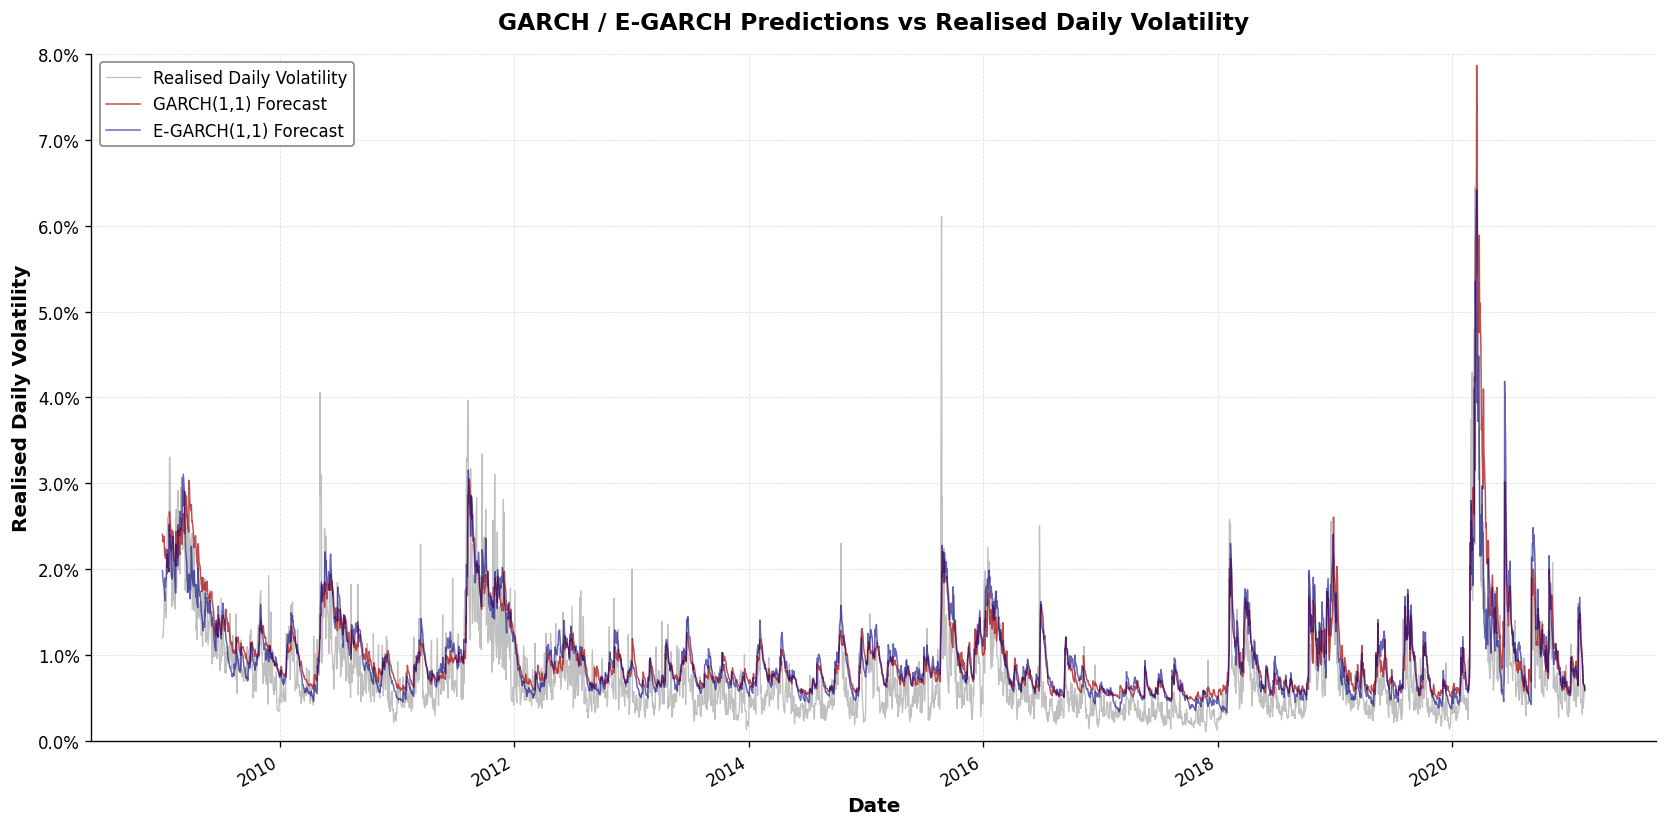

In [ ]:
merged_ge = pd.DataFrame(index=results_egarch.index.copy())

merged_ge["True_Vol"]   = results_egarch["True_Vol"]
merged_ge["EGARCH_Vol"] = results_egarch["EGARCH_Vol"]

# Align the GARCH series to the same index (normally identical, but done for safety)
merged_ge["GARCH_Vol"] = results_garch["GARCH_Vol"].reindex(merged_ge.index)

# Remove any remaining NaN values
merged_ge = merged_ge.dropna()

# Ensure the index is a DatetimeIndex
if not isinstance(merged_ge.index, pd.DatetimeIndex):
    merged_ge.index = pd.to_datetime(merged_ge.index)

plot_dates = merged_ge.index

# Convert series to percentages
true_pct   = merged_ge["True_Vol"]   * 100
garch_pct  = merged_ge["GARCH_Vol"]  * 100
egarch_pct = merged_ge["EGARCH_Vol"] * 100


# 2. Plot GARCH vs E-GARCH using the same style

plt.style.use("default")

fig, ax = plt.subplots(figsize=(14, 7), dpi=120)
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

# Realised volatility (light grey)
ax.plot(
    plot_dates, true_pct,
    color="silver", linewidth=0.8, alpha=1.0,
    label="Realised Daily Volatility"
)

# GARCH(1,1) (brick red)
ax.plot(
    plot_dates, garch_pct,
    color="firebrick", linewidth=0.9, alpha=0.8,
    label="GARCH(1,1) Forecast"
)

# E-GARCH(1,1) (navy blue)
ax.plot(
    plot_dates, egarch_pct,
    color="navy", linewidth=0.9, alpha=0.6,
    label="E-GARCH(1,1) Forecast"
)

# Titles and axes
ax.set_title(
    "GARCH / E-GARCH Predictions vs Realised Daily Volatility",
    fontsize=14, fontweight="bold", pad=15
)
ax.set_ylabel("Realised Daily Volatility", fontsize=12, fontweight="bold")
ax.set_xlabel("Date", fontsize=12, fontweight="bold")

# Grid
ax.grid(
    True, which="major", color="#d9d9d9",
    linestyle="--", linewidth=0.5, alpha=0.8
)

# Y-axis in percentage, 0–8%
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
ax.set_ylim(0, 8)

# X-axis: ticks every 2 years
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
fig.autofmt_xdate()

# Clean up spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.8)
ax.spines["bottom"].set_linewidth(0.8)

# Legend
ax.legend(
    frameon=True, fontsize=10, loc="upper left",
    framealpha=0.95, facecolor="white", edgecolor="grey"
)

plt.tight_layout()

# Save PDF (optional)
try:
    save_path = os.path.join(OUT_DIR, "garch_egarch_forecast_comparison.pdf")
    plt.savefig(save_path, format="pdf", bbox_inches="tight")
    print(f"Graph successfully saved to: {save_path}")
except Exception as e:
    print(f"Could not save PDF (check OUT_DIR): {e}")

plt.show()
